# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [1]:
# import the necessary packages

from google.cloud import storage
import pandas as pd
import numpy as np

# show all columns
pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

# import function files and environment variables
import utils

# reload the imports
import importlib

# Import the plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# Import the needed ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
import tensorflow as tf
import xgboost as xgb

2024-04-09 22:50:33.344446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = 'GOOGLE_APPLICATION_CREDENTIALS.json'
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [3]:
importlib.reload(utils)

<module 'utils' from '/Users/topanga37/github/DATASCI207_Sec03/Final Project/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [ ]:
# Read in the raw data
raw_df_2001 = pd.read_sas(utils.read_cloud_data(bucket, '2001.sas7bdat'), format='sas7bdat') 
#raw_df_2002 = pd.read_csv(utils.read_cloud_data(bucket, '2002.tab'), sep='\t', lineterminator='\n')
#raw_df_2003 = pd.read_sas(utils.read_cloud_data(bucket, '2003.sas7bdat'), format='sas7bdat') 

In [ ]:
# Run a function to make the data readable
df_2001 = utils.make_readable(raw_df_2001, variable_values_df)
#df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)
#df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)

# Filter and Clean Data

In [ ]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index(drop=True) # temporarily doing 2001 only so that the code runs faster
all_records = utils.remove_nan_values(all_records)

Age Unknown: 0

Total Null Values: 2
Total Records: 813138
Total Columns: 61


In [ ]:
all_records.notnull().sum()

DataYear               813138
RecNumbr               813136
MR                     813138
VISHEAR                813138
PHYDIS                 813138
                        ...  
dischargeReason        813138
raceEthnicity          813138
everAdopted            813138
diagnosedDisability    813138
age2021                813138
Length: 61, dtype: int64

In [ ]:
# keep only the cases where the child has exited foster care
exited_df = all_records[all_records['Exited'] == 1]
print(exited_df.shape)

(268761, 61)


In [ ]:
# Create Binary label for if they have reunified
exited_df['reunified'] = 0
exited_df.loc[(exited_df['Exited'] == 1) & (exited_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1

/var/folders/nn/49kzzxpn0r91n0t4vclvggy40000gn/T/ipykernel_93934/186036490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exited_df['reunified'] = 0


In [ ]:
# Drop columns that are are duplicative
exited_df = exited_df.drop(columns=['Exited', 'dischargeReason'])

# Visualizing the data

In [ ]:
chart_df = exited_df[exited_df['AgeAtEnd'] <= 21]

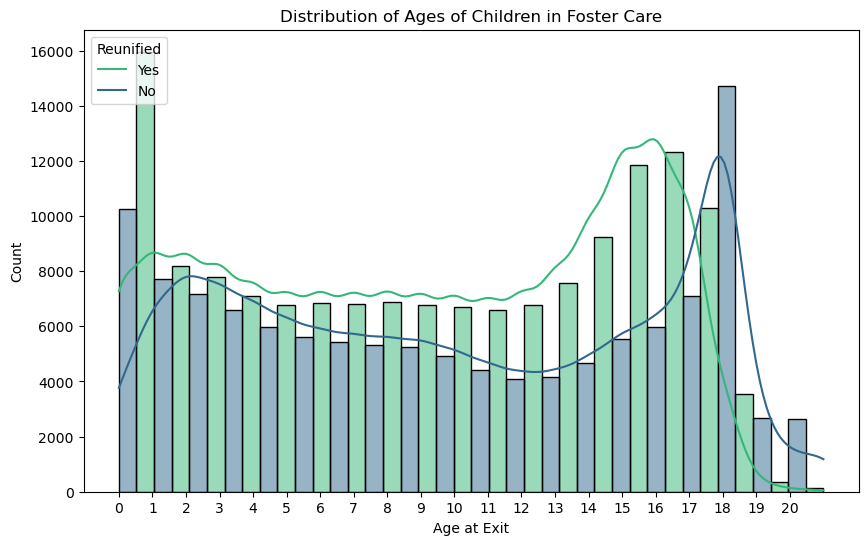

In [ ]:
# Create a histogram of the ages of the children in the dataset separated by whether they were reunified or not
plt.figure(figsize=(10, 6))
sns.histplot(chart_df, x='AgeAtEnd', hue='reunified', bins=20, kde=True, palette='viridis', multiple='dodge')
plt.title('Distribution of Ages of Children in Foster Care')
plt.xlabel('Age at Exit')
plt.ylabel('Count')
plt.xticks(np.arange(0, 21, 1))
plt.legend(title='Reunified', labels=['Yes', 'No'], loc='upper left')
# for p in plt.gca().patches:
    # plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

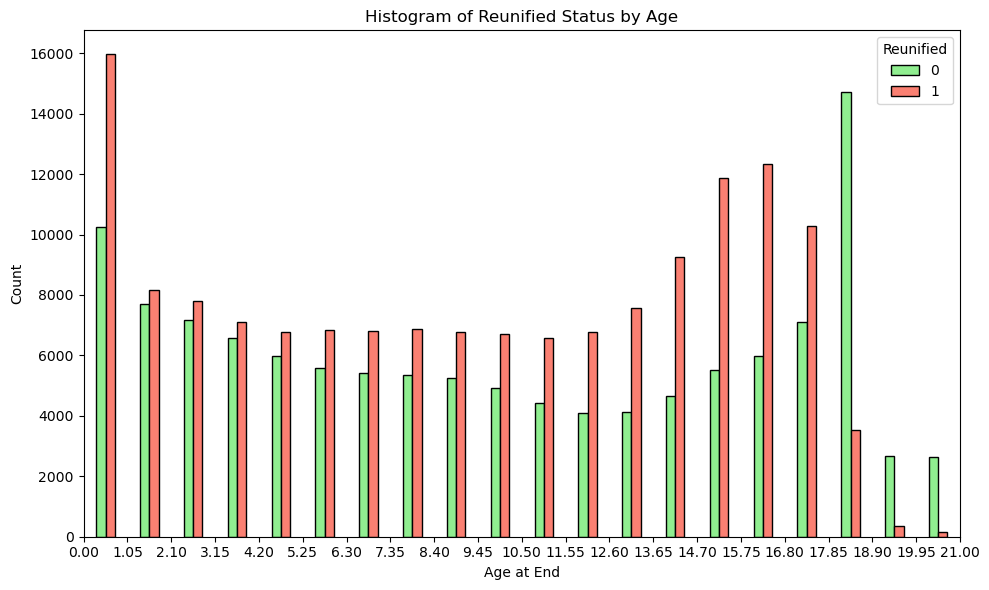

In [ ]:
# Filter the DataFrame for each category in 'reunified'
group1 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[0]]['AgeAtEnd']
group2 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[1]]['AgeAtEnd']

plt.figure(figsize=(10, 6))

# Set the positions of the bars
bins = np.histogram_bin_edges(chart_df['AgeAtEnd'], bins=20)
width = (bins[1] - bins[0]) * 0.4

plt.hist([group1, group2], bins=bins, label=[str(chart_df['reunified'].unique()[0]), str(chart_df['reunified'].unique()[1])], 
         color=['lightgreen', 'salmon'], edgecolor='black', rwidth=width, align='mid', histtype='bar')

plt.legend(title='Reunified')
plt.xlabel('Age at End')
plt.ylabel('Count')
plt.title('Histogram of Reunified Status by Age')

plt.xticks(bins.round(2))
plt.xlim([bins.min(), bins.max()])  
plt.tight_layout()
plt.show()


Text(0, 0.5, '% Reunified')

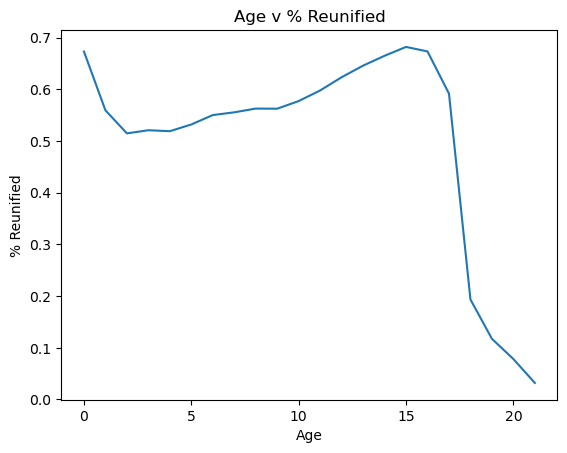

In [ ]:
# plot age v % that reunified
age_reunified = chart_df.groupby('AgeAtEnd')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

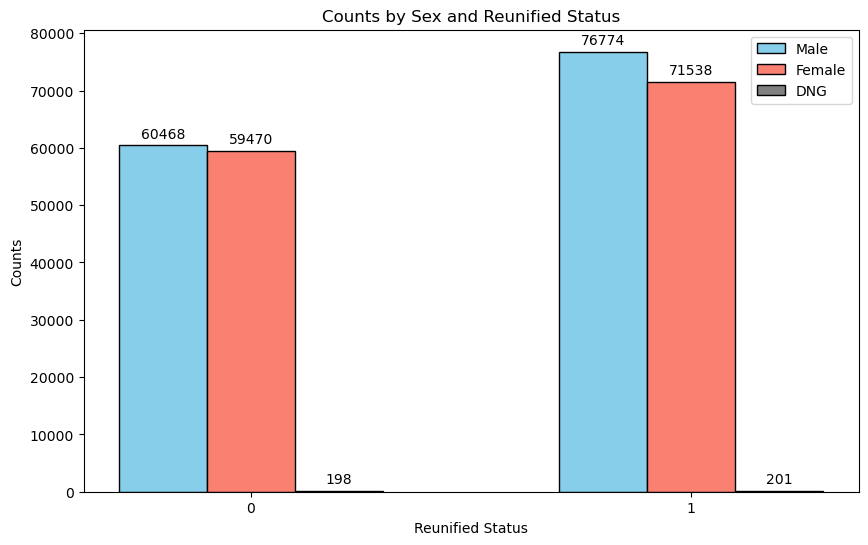

In [ ]:
count_matrix = chart_df.groupby(['reunified', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(count_matrix))
width = 0.2 # the width of the bars

# Plotting the bars
bars1 = ax.bar(ind - width, count_matrix['Male'], width, label='Male', color='skyblue', edgecolor='black')
bars2 = ax.bar(ind, count_matrix['Female'], width, label='Female', color='salmon', edgecolor='black')
bars3 = ax.bar(ind + width, count_matrix['DNG'], width, label='DNG', color='grey', edgecolor='black')

ax.set_xlabel('Reunified Status')
ax.set_ylabel('Counts')
ax.set_title('Counts by Sex and Reunified Status')
ax.set_xticks(ind)
ax.set_xticklabels(count_matrix.index)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
ax.bar_label(bars3, padding=3)

plt.show()


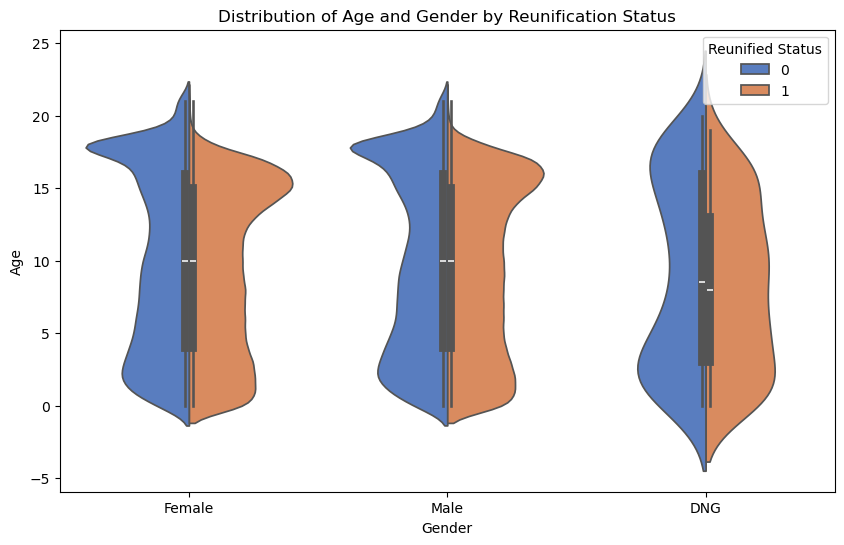

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sex", y="AgeAtEnd", hue="reunified", data=chart_df, palette="muted", split=True)

plt.title('Distribution of Age and Gender by Reunification Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Reunified Status')

plt.show()

# Creating Train-Validation-Test Datasets

In [ ]:
# Shuffle the data randomly to avoid any biases
exited_df = exited_df.sample(frac = 1, random_state=42)

In [ ]:
# Split the data into three sections: training at 60%, validation at 20%, and testing at 20%
ml_data_df = exited_df.drop(['DataYear', 'RecNumbr', 'age2021', 'caseGoal', 'AgeAtStart', 'AgedOut'], axis=1)
ml_df = pd.get_dummies(ml_data_df, columns=['State', 'FIPSCode', 'Sex', 'removalManner', 'currentPlacementSetting', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement']) 

X = ml_df.drop('reunified', axis=1)  # Features
y = ml_df['reunified']  # Target variable


# Scale X but keep the feature names
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = pd.DataFrame(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(161256, 266)
(53752, 266)
(53753, 266)


## Baseline the Model

In [ ]:
# Look at the baseline for the training dataset 
print(f"Not Reunified in Training Data: {y_train.value_counts()[0]}")
print(f"Reunified in Training Data: {y_train.value_counts()[1]}")
baseline = y_train.value_counts()[1] / len(y_train)
print(f"\nPercentage Reunified, Training Baseline: {round(baseline*100, 2)}%")

Not Reunified in Training Data: 72236
Reunified in Training Data: 89020

Percentage Reunified, Training Baseline: 55.2%


In [ ]:
# Calculate the baseline loss for the training dataset

def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.
  
  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """
  loss = -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
  return loss

# Use the log_loss function to evaluate our baseline on the train, validation, and test dataset using the average of reunified as our predicted probability.

train_loss = log_loss(y_train, baseline)
val_loss = log_loss(y_val, baseline)
test_loss = log_loss(y_test, baseline)

print("Log Loss for Baseline on Training Dataset:", train_loss)
print("Log Loss for Baseline on Validation Dataset:", val_loss)
print("Log Loss for Baseline on Test Dataset:", test_loss)

Log Loss for Baseline on Training Dataset: 0.687720727851345
Log Loss for Baseline on Validation Dataset: 0.6880679474105265
Log Loss for Baseline on Test Dataset: 0.6867213968889204


# ALL ABOVE CODE IS SET FOR MODEL TESTING

# Random Forest

In [ ]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = rf.predict(X_train)

# Accuracy
print('Training Accuracy : ', 
      metrics.accuracy_score(y_train,
                             rf.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf.predict(X_val))*100)

# Classification report
print('Classification Report, Validation:\n', classification_report(y_val, rf.predict(X_val)))

Training Accuracy :  99.95969142233467
Validation Accuracy :  85.6749516297068
Classification Report, Validation:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83     24168
           1       0.84      0.91      0.88     29584

    accuracy                           0.86     53752
   macro avg       0.86      0.85      0.85     53752
weighted avg       0.86      0.86      0.86     53752



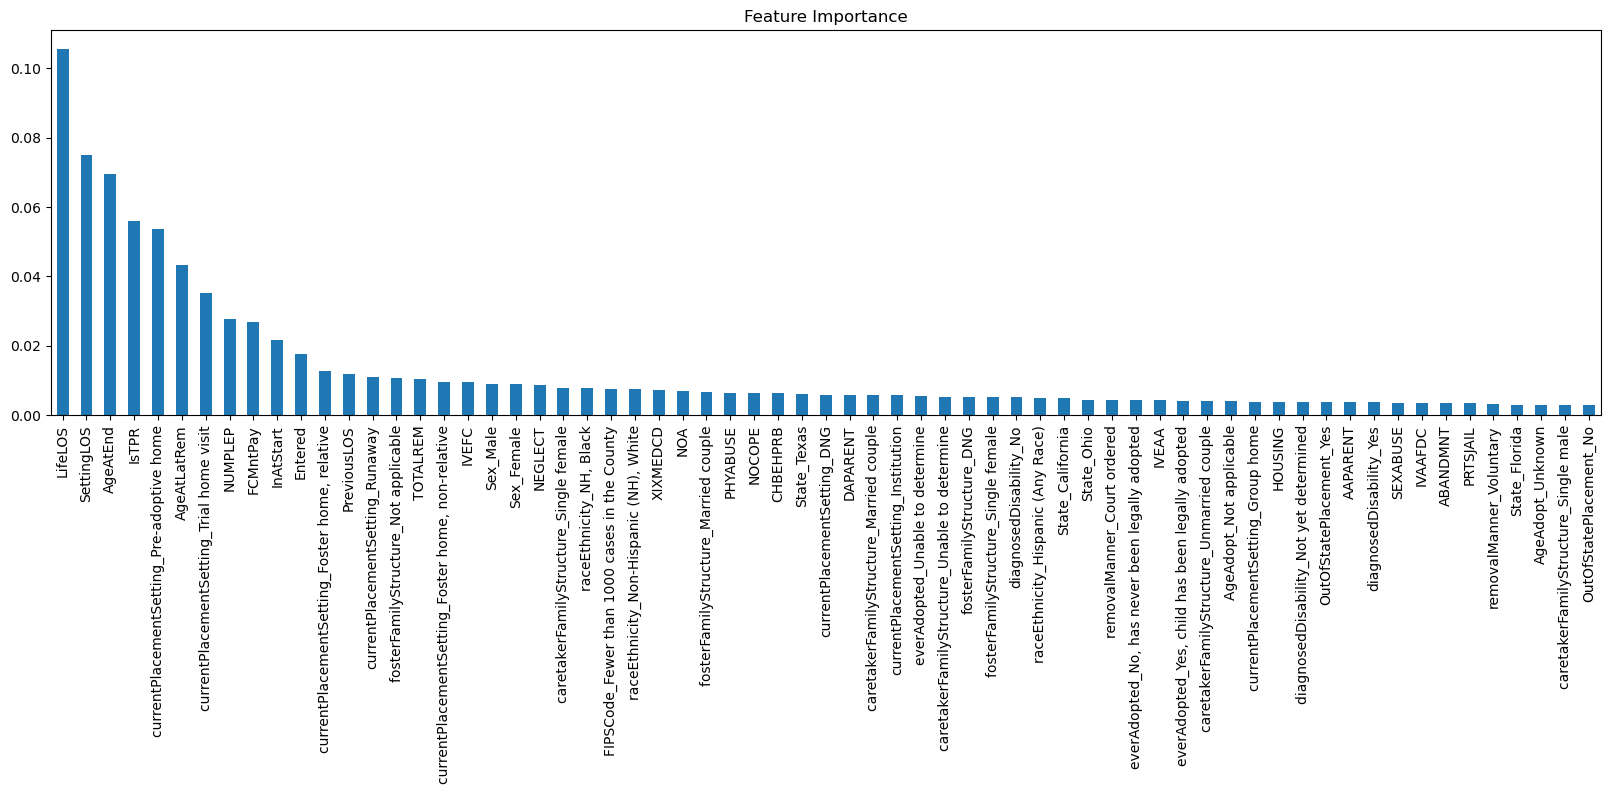

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances[:65].plot(kind='bar', figsize=(20, 5))
plt.title('Feature Importance')
plt.show()


[[19073  5095]
 [ 2605 26979]]


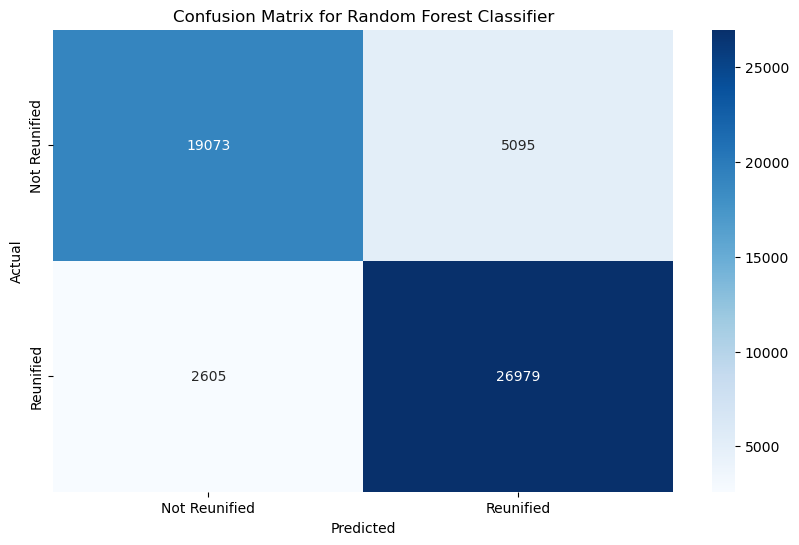

In [ ]:
y_pred_val = rf.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

1 0.6959306940516942
1 0.6956020241107308
4 0.7672768765193233
4 0.7645482958773627
7 0.7864699608076599
7 0.7838219973210299
10 0.80516073820509
10 0.8005283524333978
13 0.8243972317309123
13 0.8138487870218782
16 0.8439685965173389
16 0.8239321327578508
19 0.8638624299250881
19 0.8307411817234708
22 0.8914893089249393
22 0.8375688346480131
25 0.9144776008334573
25 0.8437081410924244
28 0.938067420747135
28 0.8469638339038548
31 0.9560822543037159
31 0.8507404375651139
34 0.9714677283325892
34 0.8532519720196458
37 0.9845215061765143
37 0.853419407649948
40 0.9906918192191299
40 0.8550379520762018
43 0.9948218980999156
43 0.8566006846256884
46 0.9970543731706107
46 0.856544872748921
49 0.9983256436969787
49 0.855819318350945


Text(0.5, 0, 'Tree depth')

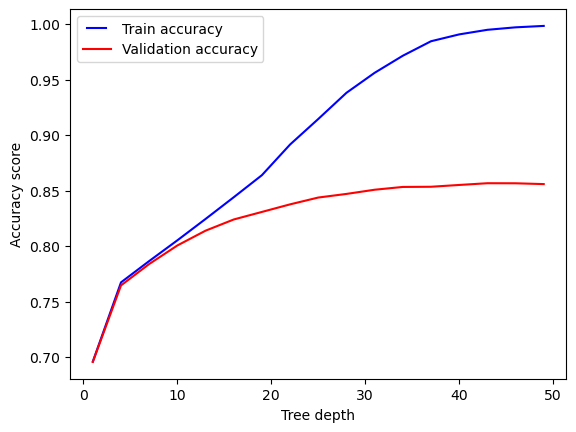

In [ ]:
max_depths = np.arange(1, 50, 3)

train_results = []
val_results = []

for i in max_depths:
    dt = RandomForestClassifier(max_depth=i)
    dt.fit(X_train, y_train)    

    # Calculate and display accuracy
    accuracy = metrics.accuracy_score(y_train, dt.predict(X_train))
    #append results of accuracy
    print(i, accuracy)
    train_results.append(accuracy)
    
    #now again for test data
    accuracy = metrics.accuracy_score(y_val, dt.predict(X_val))
    #append results of accuracy
    print(i, accuracy)
    val_results.append(accuracy)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, val_results, 'r', label= 'Validation accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')

1 0.7802500372079179
1 0.7651064146450365
4 0.8242732053380959
4 0.8075792528650096
7 0.8289614029865555
7 0.8107419258818277
10 0.8301520563575929
10 0.8145743414198542
13 0.8341084982884358
13 0.8172719154636107
16 0.8371161383142333
16 0.8190392915612442
19 0.836061913975294
19 0.8196532222056854
22 0.8371657488713599
22 0.8200253013841345
25 0.8346046038597014
25 0.8186486084238725
28 0.8341643101652032
28 0.8171602917100759
31 0.8364401944733839
31 0.8209368953713351
34 0.8357270427146897
34 0.8198020538770651
37 0.8368060723321923
37 0.8189834796844768
40 0.835509996527261
40 0.8198206578359875
43 0.8356526268789999
43 0.8193183509450811
46 0.8344743761472442
46 0.8192625390683137
49 0.8346542144168279
49 0.81983926179491


Text(0.5, 0, 'Estimators')

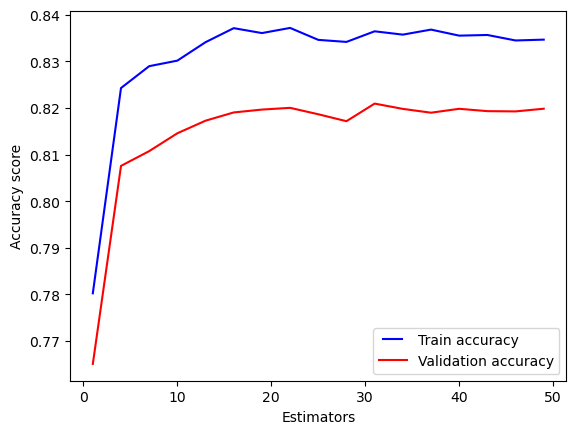

In [ ]:
n_estimators = np.arange(1, 50, 3)

train_results = []
val_results = []

for i in n_estimators:
    dt = RandomForestClassifier(max_depth=15, n_estimators=i)
    dt.fit(X_train, y_train)    

    # Calculate and display accuracy
    accuracy = metrics.accuracy_score(y_train, dt.predict(X_train))
    #append results of accuracy
    print(i, accuracy)
    train_results.append(accuracy)
    
    #now again for test data
    accuracy = metrics.accuracy_score(y_val, dt.predict(X_val))
    #append results of accuracy
    print(i, accuracy)
    val_results.append(accuracy)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, val_results, 'r', label= 'Validation accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Estimators')

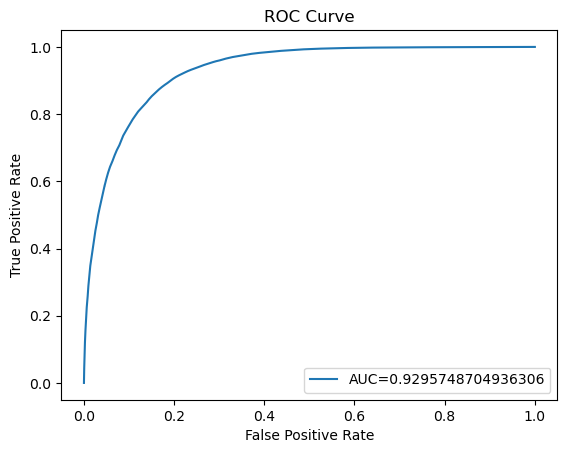

In [ ]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

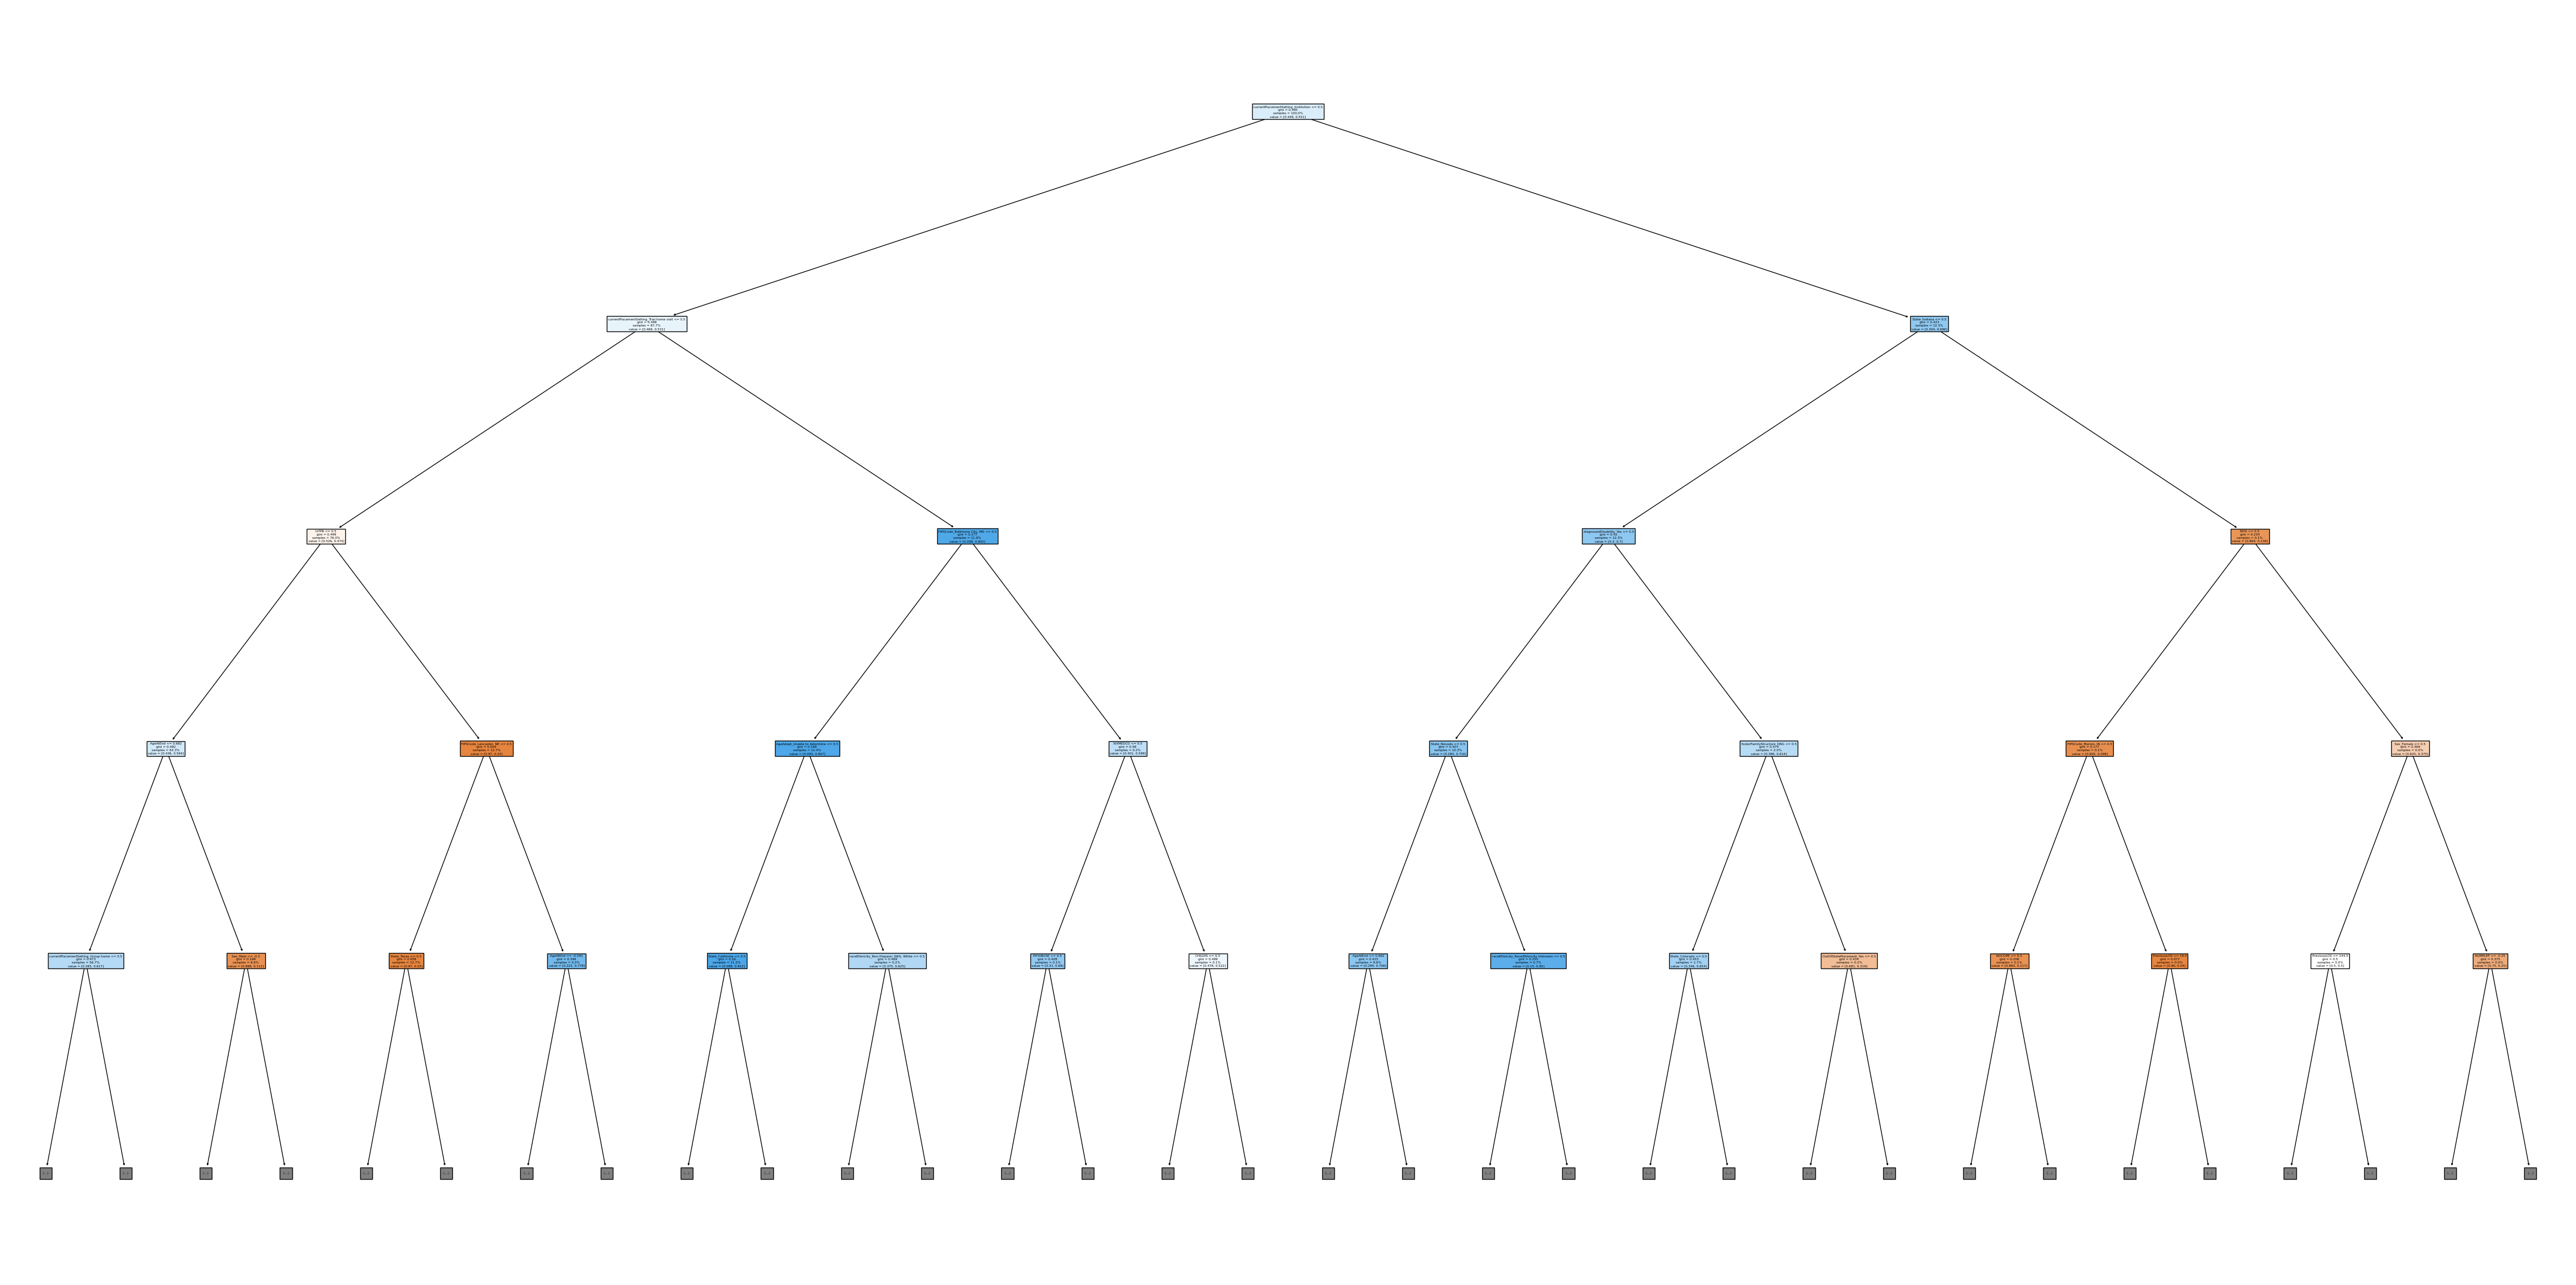

In [ ]:
# Pick a single tree from the forest
single_tree = rf.estimators_[0]

plt.figure(figsize=(60,30))
plot_tree(single_tree, filled=True, feature_names=X.columns, max_depth=4, proportion=True)
plt.show()

In [186]:
# Drop all rows that start with "state_"
X_train_trial = X_train.loc[:, ~X_train.columns.str.startswith('State_')]
X_val_trial = X_val.loc[:, ~X_val.columns.str.startswith('State_')]
X_test_trial = X_test.loc[:, ~X_test.columns.str.startswith('State_')]

# Drop all rows that start with "FIPSCode_"
X_train_trial = X_train_trial.loc[:, ~X_train_trial.columns.str.startswith('FIPSCode_')]
X_val_trial = X_val_trial.loc[:, ~X_val_trial.columns.str.startswith('FIPSCode_')]
X_test_trial = X_test_trial.loc[:, ~X_test_trial.columns.str.startswith('FIPSCode_')]

In [187]:
# Create new binary category for Disability-Condition

# Create a new column DISABCOND
X_train_trial['DISABCOND'] = 0
X_val_trial['DISABCOND'] = 0
X_test_trial['DISABCOND'] = 0

# If MR, CLINDIS, VISHEAR, PHYDIS, DMSII, or OTHERMED is 1, then update the DISABCOND column to 1
X_train_trial.loc[(X_train_trial['MR'] == 1) | (X_train_trial['VISHEAR'] == 1) | (X_train_trial['PHYDIS'] == 1) | 
                 (X_train_trial['DSMIII'] == 1) | (X_train_trial['OTHERMED'] == 1) | 
                (X_train_trial['diagnosedDisability_Yes'] == 'True'), 'DISABCOND'] = 1

X_val_trial.loc[(X_val_trial['MR'] == 1) | (X_val_trial['VISHEAR'] == 1) | (X_val_trial['PHYDIS'] == 1) | 
                 (X_val_trial['DSMIII'] == 1) | (X_val_trial['OTHERMED'] == 1) | 
                (X_val_trial['diagnosedDisability_Yes'] == 'True'), 'DISABCOND'] = 1

X_test_trial.loc[(X_test_trial['MR'] == 1) | (X_test_trial['VISHEAR'] == 1) | (X_test_trial['PHYDIS'] == 1) | 
                 (X_test_trial['DSMIII'] == 1) | (X_test_trial['OTHERMED'] == 1) | 
                (X_test_trial['diagnosedDisability_Yes'] == 'True'), 'DISABCOND'] = 1

# Drop the columns that were used to create the new column
X_train_trial = X_train_trial.drop(columns=['MR', 'VISHEAR', 'PHYDIS', 'DSMIII', 'OTHERMED', 'diagnosedDisability_DNG', 
                                           'diagnosedDisability_No', 'diagnosedDisability_Not yet determined', 'diagnosedDisability_Yes'])

X_val_trial = X_val_trial.drop(columns=['MR', 'VISHEAR', 'PHYDIS', 'DSMIII', 'OTHERMED', 'diagnosedDisability_DNG', 
                                           'diagnosedDisability_No', 'diagnosedDisability_Not yet determined', 'diagnosedDisability_Yes'])

X_test_trial = X_test_trial.drop(columns=['MR', 'VISHEAR', 'PHYDIS', 'DSMIII', 'OTHERMED', 'diagnosedDisability_DNG',
                                            'diagnosedDisability_No', 'diagnosedDisability_Not yet determined', 'diagnosedDisability_Yes'])


In [188]:
# Initialize the model
rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_1.fit(X_train_trial, y_train)

# Accuracy
print('Training Accuracy : ', 
      metrics.accuracy_score(y_train,
                             rf_1.predict(X_train_trial))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf_1.predict(X_val_trial))*100)

# Classification report
print('Classification Report, Validation:\n', classification_report(y_val, rf_1.predict(X_val_trial)))

Training Accuracy :  99.93736667162773
Validation Accuracy :  84.2759339187379
Classification Report, Validation:
               precision    recall  f1-score   support

           0       0.87      0.77      0.81     24168
           1       0.83      0.91      0.86     29584

    accuracy                           0.84     53752
   macro avg       0.85      0.84      0.84     53752
weighted avg       0.85      0.84      0.84     53752



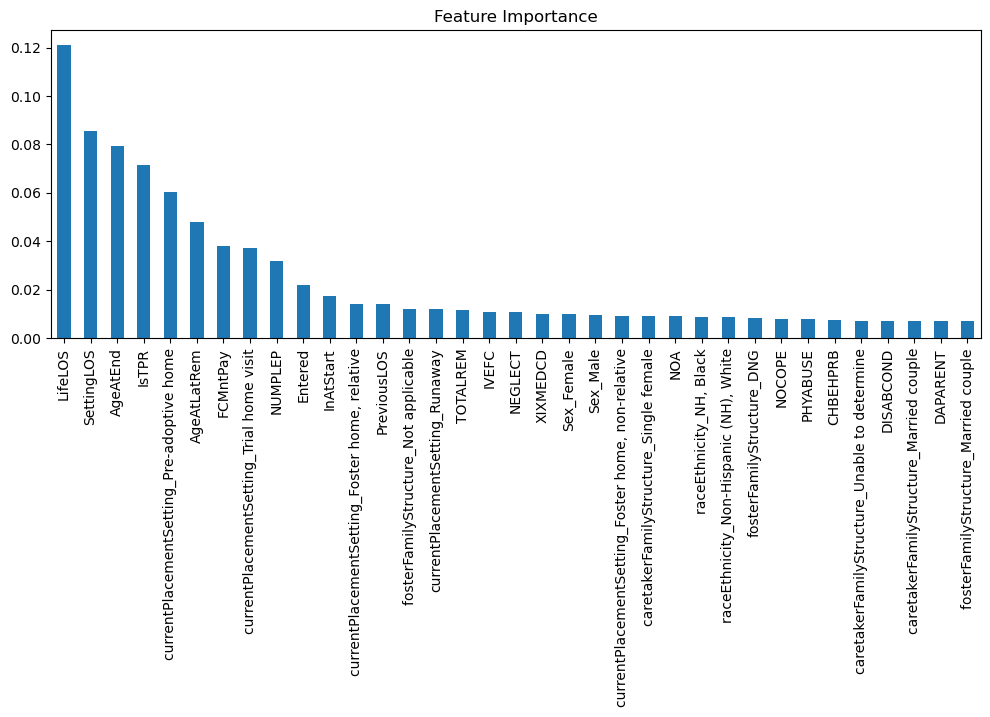

In [191]:
feature_importances_1 = pd.Series(rf_1.feature_importances_, index=X_train_trial.columns).sort_values(ascending=False)
feature_importances_1[:35].plot(kind='bar', figsize=(12, 4))
plt.title('Feature Importance')
plt.show()

[[18500  5668]
 [ 2784 26800]]


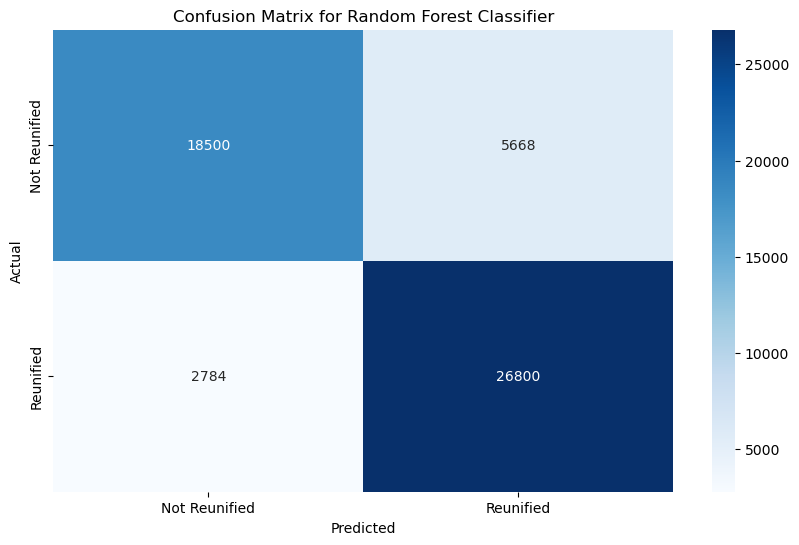

In [190]:
# Predictions
y_pred_val = rf_1.predict(X_val_trial)

cm_1 = confusion_matrix(y_val, y_pred_val)
print(cm_1)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm_1, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

# XG Boost Model

In [86]:
# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Specify model training parameters
params = {
    'max_depth': 100,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 250
bst = xgb.train(params, dtrain, num_rounds)

In [87]:
# Making predictions
y_pred_proba = bst.predict(dval)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))

Accuracy: 0.8587959517785385
              precision    recall  f1-score   support

           0       0.87      0.81      0.84     24168
           1       0.85      0.90      0.88     29584

    accuracy                           0.86     53752
   macro avg       0.86      0.85      0.86     53752
weighted avg       0.86      0.86      0.86     53752



In [ ]:
# from sklearn.model_selection import GridSearchCV

# xgb_model = xgb.XGBClassifier()
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging_classifier', bagging_classifier)
])

# Train the model
pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('bagging_classifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                   n_estimators=100, random_state=42))])

In [96]:
y_pred_bag = pipeline.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred_bag)}")
print(classification_report(y_val, y_pred_bag))

Accuracy: 0.8589447834499181
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     24168
           1       0.85      0.91      0.88     29584

    accuracy                           0.86     53752
   macro avg       0.86      0.85      0.86     53752
weighted avg       0.86      0.86      0.86     53752



## PCA for Feature Selection

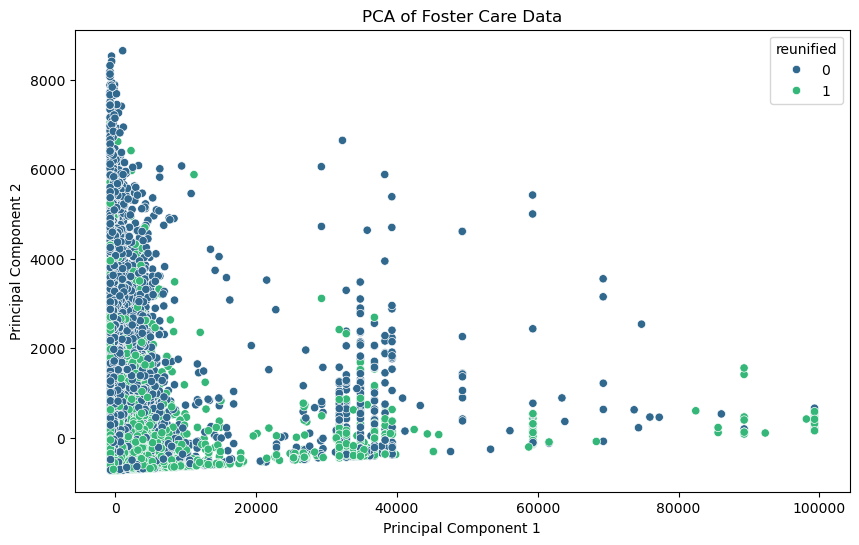

In [98]:
# Set up a PCA model to see what features are most helpful
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_train)

# Plot the PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis')
plt.title('PCA of Foster Care Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



# KNN Model

In [ ]:
# KNN Model

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# CNN Model

In [ ]:
age = np.array(X_train['AgeAtEnd'])[10:20]
print("Ages:", age)

age_bins = [0, 5, 10, 15, 20]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
print("Age Bins:", age_binned)

age_id = tf.keras.layers.IntegerLookup(vocabulary=np.arange(0, len(age_bins)+1), output_mode='one_hot')(age_binned)
print('Ages as one-hot:', age_id)

In [ ]:
def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')

    age_bins = [0, 5, 10, 15, 20, 30]
    age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(age_bins)+1),
        output_mode='one_hot')(age_binned)
    
    sex_id = tf.keras.layers.StringLookup(
        vocabulary=['Male', 'Female', 'DNG'], output_mode='one_hot')(sex)
    
    features = tf.keras.layers.Concatenate()([age_id, sex_id])

    dense = tf.keras.layers.Dense(
        units=12, activation='tanh', name='hidden1')(features)

    reunified = tf.keras.layers.Dense(
        units=1, activation='sigmoid', name='reunified')(dense)

    model = tf.keras.Model(inputs=[age, sex], 
                           outputs=reunified, 
                           name='Foster')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
history = model.fit(
    x = {
        'Age': ml_data_df['AgeAtEnd'], 
        'Sex': ml_data_df['Sex']
        },
    y = ml_data_df['reunified'],
    validation_data=(
        {
            'Age': ml_data_df['AgeAtEnd'], 
            'Sex': ml_data_df['Sex']
        },
        ml_data_df['reunified']),
    epochs=10,
    batch_size=32
)

In [ ]:
print("Concatenate - Accuracy: 0.5439")